## 6.4 Machine Learning Part Task

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Data cleaning
        - Missing values
        - Duplicates
        - Data types
#### 3. Deriving new columns & Data wrangling
#### 4. Exploring relationships
        - Create a correlation heatmap
        - Create a scatterplot
        - Create a categorical plot
        - Checking extreme values
#### 5. Data prep for regression analysis
#### 6. Regression analysis
#### 7. Performance improvement after removing outliers?

### 1. Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree, preprocessing

In [2]:
# This option ensures that the graphs created are displayed within the notebook without the need to "call" them specifically.

%matplotlib inline

In [3]:
# Define path

path = r'/Users/faridchehraz/Desktop/Python/Master - USA Wildfires'

In [4]:
#Import US_wildfires pkl file

df = pd.read_pickle(os.path.join(path, '2. Data', 'b. Prepared Data', 'US_wildfires.pkl'))

### 2. Data cleaning

In [5]:
df.columns

Index(['FOD_ID', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'NWCG_GENERAL_CAUSE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_NAME',
       'DISC_MONTH', 'DISC_DOW'],
      dtype='object')

In [6]:
df.head()

,FOD_ID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,NWCG_GENERAL_CAUSE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,COUNTY,FIPS_NAME,DISC_MONTH,DISC_DOW
0,1,2005,2005-02-02,33,Power generation/transmission/distribution,0.10,A,40.036944,-121.005833,USFS,CA,63,Plumas County,2,Wednesday
1,2,2004,2004-05-12,133,Natural,0.25,A,38.933056,-120.404444,USFS,CA,61,Placer County,5,Wednesday
2,3,2004,2004-05-31,152,Debris and open burning,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,17,El Dorado County,5,Monday
3,4,2004,2004-06-28,180,Natural,0.10,A,38.559167,-119.913333,USFS,CA,3,Alpine County,6,Monday
4,5,2004,2004-06-28,180,Natural,0.10,A,38.559167,-119.933056,USFS,CA,3,Alpine County,6,Monday


##### Missing values

In [7]:
# Check for missing values

df.isnull().sum()

# Will not add missing county names

FOD_ID                     0
FIRE_YEAR                  0
DISCOVERY_DATE             0
DISCOVERY_DOY              0
NWCG_GENERAL_CAUSE         0
FIRE_SIZE                  0
FIRE_SIZE_CLASS            0
LATITUDE                   0
LONGITUDE                  0
OWNER_DESCR                0
STATE                      0
COUNTY                657235
FIPS_NAME             657236
DISC_MONTH                 0
DISC_DOW                   0
dtype: int64

##### Duplicates check

In [8]:
dups = df.duplicated()

In [9]:
dups.shape # No dups

(2166753,)

##### Data type check

In [10]:
df.dtypes

FOD_ID                         int64
FIRE_YEAR                      int64
DISCOVERY_DATE        datetime64[ns]
DISCOVERY_DOY                  int64
NWCG_GENERAL_CAUSE            object
FIRE_SIZE                    float64
FIRE_SIZE_CLASS               object
LATITUDE                     float64
LONGITUDE                    float64
OWNER_DESCR                   object
STATE                         object
COUNTY                        object
FIPS_NAME                     object
DISC_MONTH                     int64
DISC_DOW                      object
dtype: object

### 3. Deriving new columns & Data wrangling

In [11]:
#Derive Fire_Size_Desc column using If-statement with the loc() function

df.loc[df['FIRE_SIZE_CLASS'] == 'A', 'Fire_Size_Desc'] = '0.0 - 0.25 Acres'
df.loc[df['FIRE_SIZE_CLASS'] == 'B', 'Fire_Size_Desc'] = '0.26 - 9.9 Acres'
df.loc[df['FIRE_SIZE_CLASS'] == 'C', 'Fire_Size_Desc'] = '10.0 - 99.9 Acres'
df.loc[df['FIRE_SIZE_CLASS'] == 'D', 'Fire_Size_Desc'] = '100 - 299 Acres'
df.loc[df['FIRE_SIZE_CLASS'] == 'E', 'Fire_Size_Desc'] = '300 - 999 Acres'
df.loc[df['FIRE_SIZE_CLASS'] == 'F', 'Fire_Size_Desc'] = '1000 - 4999 Acres'
df.loc[df['FIRE_SIZE_CLASS'] == 'G', 'Fire_Size_Desc'] = '5000+ Acres'

In [12]:
df['NWCG_GENERAL_CAUSE'].value_counts().sort_index(ascending=True)

Arson/incendiarism                            310320
Debris and open burning                       507219
Equipment and vehicle use                     175824
Firearms and explosives use                     2205
Fireworks                                      17205
Missing data/not specified/undetermined       547438
Misuse of fire by a minor                      64630
Natural                                       312807
Other causes                                    9763
Power generation/transmission/distribution     28491
Railroad operations and maintenance            36437
Recreation and ceremony                        92725
Smoking                                        61689
Name: NWCG_GENERAL_CAUSE, dtype: int64

In [13]:
#Categorise wildfire causes & add to dataframe

def Cause_category(row):

  if row['NWCG_GENERAL_CAUSE'] in ('Natural'):
    return 'Natural'
  elif row['NWCG_GENERAL_CAUSE'] in ('Debris and open burning','Firearms and explosives use',
                                     'Misuse of fire by a minor'):
    return 'Accidental'
  elif row['NWCG_GENERAL_CAUSE'] in ('Equipment and vehicle use','Power generation/transmission/distribution',
                                   'Railroad operations and maintenance'):
    return 'Accidental Industry'
  elif row['NWCG_GENERAL_CAUSE'] in ('Arson/incendiarism'):
    return 'Malicious'
  elif row['NWCG_GENERAL_CAUSE'] in ('Fireworks','Recreation and ceremony','Smoking'):
    return 'Recreation'
  elif row['NWCG_GENERAL_CAUSE'] in ('Other causes','Missing data/not specified/undetermined'):
    return 'Other/Unknown'

  else: return np.nan

df['Cause_cat'] = df.apply(Cause_category, axis=1)

In [14]:
#Derive Cause_cat_num using If-statement with the loc() function

df.loc[df['Cause_cat'] == 'Natural', 'Cause_cat_num'] = '1'
df.loc[df['Cause_cat'] == 'Accidental', 'Cause_cat_num'] = '2'
df.loc[df['Cause_cat'] == 'Accidental Industry', 'Cause_cat_num'] = '3'
df.loc[df['Cause_cat'] == 'Malicious', 'Cause_cat_num'] = '4'
df.loc[df['Cause_cat'] == 'Recreation', 'Cause_cat_num'] = '5'
df.loc[df['Cause_cat'] == 'Other/Unknown', 'Cause_cat_num'] = '6'

In [15]:
df.dtypes

FOD_ID                         int64
FIRE_YEAR                      int64
DISCOVERY_DATE        datetime64[ns]
DISCOVERY_DOY                  int64
NWCG_GENERAL_CAUSE            object
FIRE_SIZE                    float64
FIRE_SIZE_CLASS               object
LATITUDE                     float64
LONGITUDE                    float64
OWNER_DESCR                   object
STATE                         object
COUNTY                        object
FIPS_NAME                     object
DISC_MONTH                     int64
DISC_DOW                      object
Fire_Size_Desc                object
Cause_cat                     object
Cause_cat_num                 object
dtype: object

In [16]:
#Change Cause_cat_num to int64

df['Cause_cat_num'] = df['Cause_cat_num'].astype('int64')

##### Create subset to test

In excercise 6.2, there were very few easily visible correlations. For this reason, I will focus on the sate with the largest number of wildfires

In [17]:
# get top 3 States by number of wildfires

n = 3
df['STATE'].value_counts()[:n].index.tolist()

['CA', 'GA', 'TX']

In [18]:
#Create subset for the state of California

df_CA = df[df['STATE']=='CA']

### 4. Exploring Relationships

### Correlations

#### Create a correlation heatmap using seaborn

In [19]:
df_CA.columns

Index(['FOD_ID', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'NWCG_GENERAL_CAUSE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_NAME',
       'DISC_MONTH', 'DISC_DOW', 'Fire_Size_Desc', 'Cause_cat',
       'Cause_cat_num'],
      dtype='object')

In [20]:
# Create a subset excluding the "FOD_ID", "DISCOVERY_DATE", 'FIRE_SIZE_CLASS',
#'COUNTY', 'FIPS_NAME' columns

sub = df_CA[['FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE','LONGITUDE', 'OWNER_DESCR',
       'DISC_MONTH', 'DISC_DOW','FIRE_SIZE', 'Fire_Size_Desc','NWCG_GENERAL_CAUSE','Cause_cat','Cause_cat_num']]

In [21]:
sub.head()

,FIRE_YEAR,DISCOVERY_DOY,LATITUDE,LONGITUDE,OWNER_DESCR,DISC_MONTH,DISC_DOW,FIRE_SIZE,Fire_Size_Desc,NWCG_GENERAL_CAUSE,Cause_cat,Cause_cat_num
0,2005,33,40.036944,-121.005833,USFS,2,Wednesday,0.10,0.0 - 0.25 Acres,Power generation/transmission/distribution,Accidental Industry,3
1,2004,133,38.933056,-120.404444,USFS,5,Wednesday,0.25,0.0 - 0.25 Acres,Natural,Natural,1
2,2004,152,38.984167,-120.735556,STATE OR PRIVATE,5,Monday,0.10,0.0 - 0.25 Acres,Debris and open burning,Accidental,2
3,2004,180,38.559167,-119.913333,USFS,6,Monday,0.10,0.0 - 0.25 Acres,Natural,Natural,1
4,2004,180,38.559167,-119.933056,USFS,6,Monday,0.10,0.0 - 0.25 Acres,Natural,Natural,1


In [22]:
#Convert quantitative variables to numerical values

le = preprocessing.LabelEncoder()
sub['NWCG_GENERAL_CAUSE'] = le.fit_transform(df_CA['NWCG_GENERAL_CAUSE'])
sub['DISC_DOW'] = le.fit_transform(df_CA['DISC_DOW'])
sub['Fire_Size_Desc'] = le.fit_transform(df_CA['Fire_Size_Desc'])
sub['OWNER_DESCR'] = le.fit_transform(df_CA['OWNER_DESCR'])

print(sub.head())

   FIRE_YEAR  DISCOVERY_DOY   LATITUDE   LONGITUDE  OWNER_DESCR  DISC_MONTH  \
0       2005             33  40.036944 -121.005833           15           2   
1       2004            133  38.933056 -120.404444           15           5   
2       2004            152  38.984167 -120.735556           12           5   
3       2004            180  38.559167 -119.913333           15           6   
4       2004            180  38.559167 -119.933056           15           6   

   DISC_DOW  FIRE_SIZE  Fire_Size_Desc  NWCG_GENERAL_CAUSE  \
0         6       0.10               0                   9   
1         6       0.25               0                   7   
2         1       0.10               0                   1   
3         1       0.10               0                   7   
4         1       0.10               0                   7   

             Cause_cat  Cause_cat_num  
0  Accidental Industry              3  
1              Natural              1  
2           Accidental          

/var/folders/vh/d2rsnjw92ql_ggn35h8q4vmr0000gn/T/ipykernel_1471/3621507464.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['NWCG_GENERAL_CAUSE'] = le.fit_transform(df_CA['NWCG_GENERAL_CAUSE'])
/var/folders/vh/d2rsnjw92ql_ggn35h8q4vmr0000gn/T/ipykernel_1471/3621507464.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['DISC_DOW'] = le.fit_transform(df_CA['DISC_DOW'])
/var/folders/vh/d2rsnjw92ql_ggn35h8q4vmr0000gn/T/ipykernel_1471/3621507464.py:6: SettingWithCopyWarning: 
A value is trying to be 

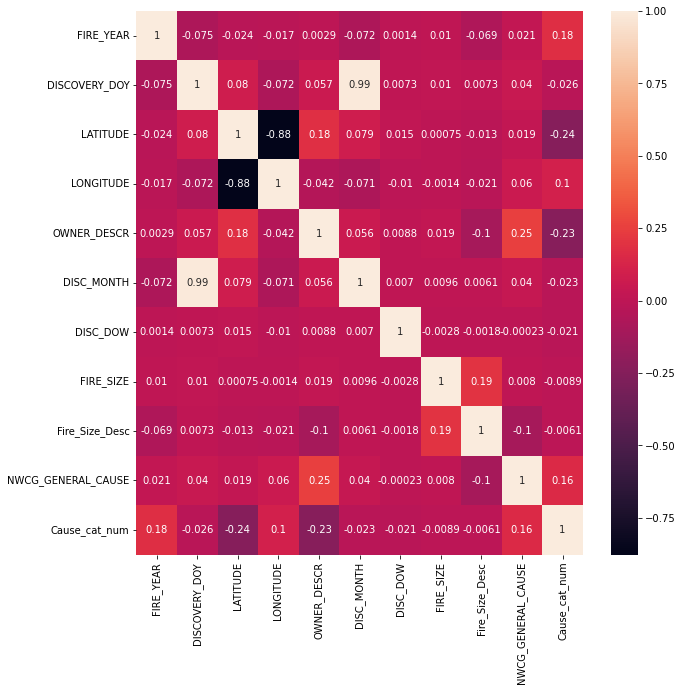

In [23]:
# Create a subplot with matplotlib

f,ax = plt.subplots(figsize=(10,10))

# Create the correlation heatmap in seaborn by applying a heatmap onto the correlation matrix and the subplots defined above.
corr = sns.heatmap(sub.corr(), annot = True, ax = ax) # The `annot` argument allows the plot to 
#place the correlation coefficients onto the heatmap.

#### Correlation Observations:

   - The more prominent and interesting correlations although weak are between:
     - Cause category & Latitude
     - Cause category & Owner description

#### Create a scatterplot using seaborn

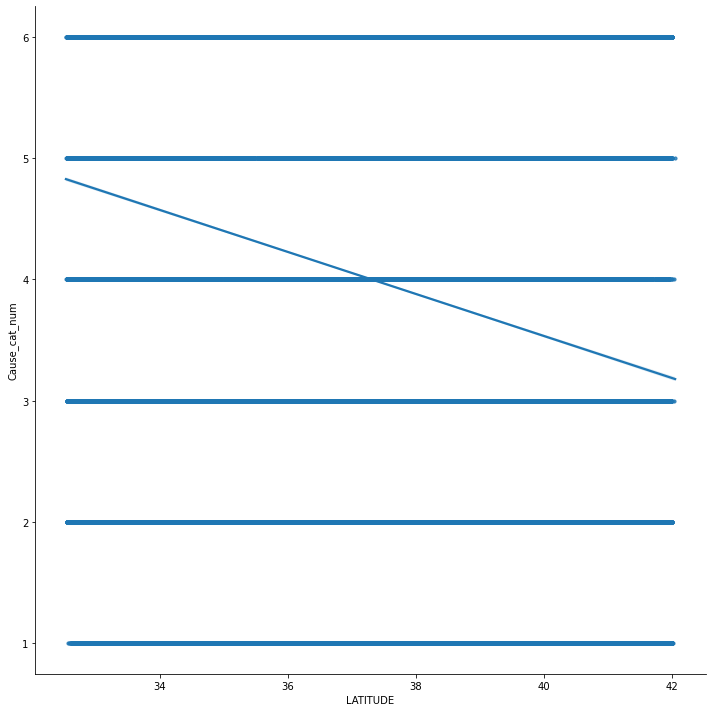

In [24]:
# Create a scatterplot for the "LATITUDE" and "Cause_cat" columns in seaborn

sns.lmplot(x = 'LATITUDE', y = 'Cause_cat_num', data = df_CA, height = 10, aspect = 1, scatter_kws={"s": 10})

The above scatterplot shows a relationship albeit weak between the cause and the latitude of wildfires

##### Create a categorical plot looking at Cause, Latitude and Fire Size for the largest 5 fire size categories 

Text(27.318530208333335, 0.5, 'Latitude')

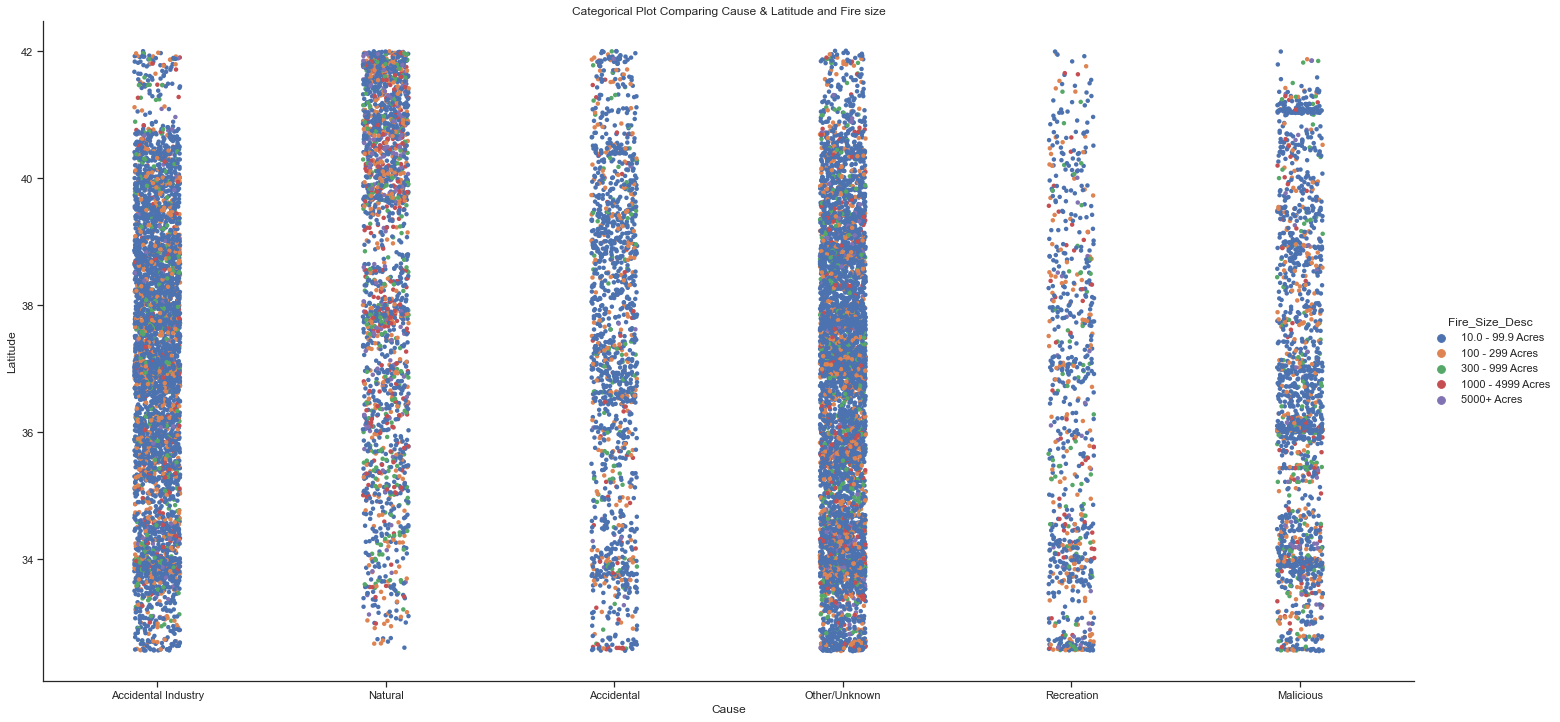

In [25]:
sns.set(style='ticks')
cat_plot = sns.catplot(x = 'Cause_cat', y = 'LATITUDE', data = df_CA, hue = 'Fire_Size_Desc', hue_order = ['10.0 - 99.9 Acres','100 - 299 Acres','300 - 999 Acres','1000 - 4999 Acres','5000+ Acres'],height=10, aspect=2, sizes=(20, 20))

plt.title('Categorical Plot Comparing Cause & Latitude and Fire size')
plt.xlabel('Cause')
plt.ylabel('Latitude')

##### Create a categorical plot looking at Cause, Latitude and Fire Size for the largest 3 fire size categories 

In [26]:
df_CA_2 = df_CA.apply(lambda row: row[df['FIRE_SIZE_CLASS'].isin(['E','F','G'])])

Text(28.408162760416666, 0.5, 'Latitude')

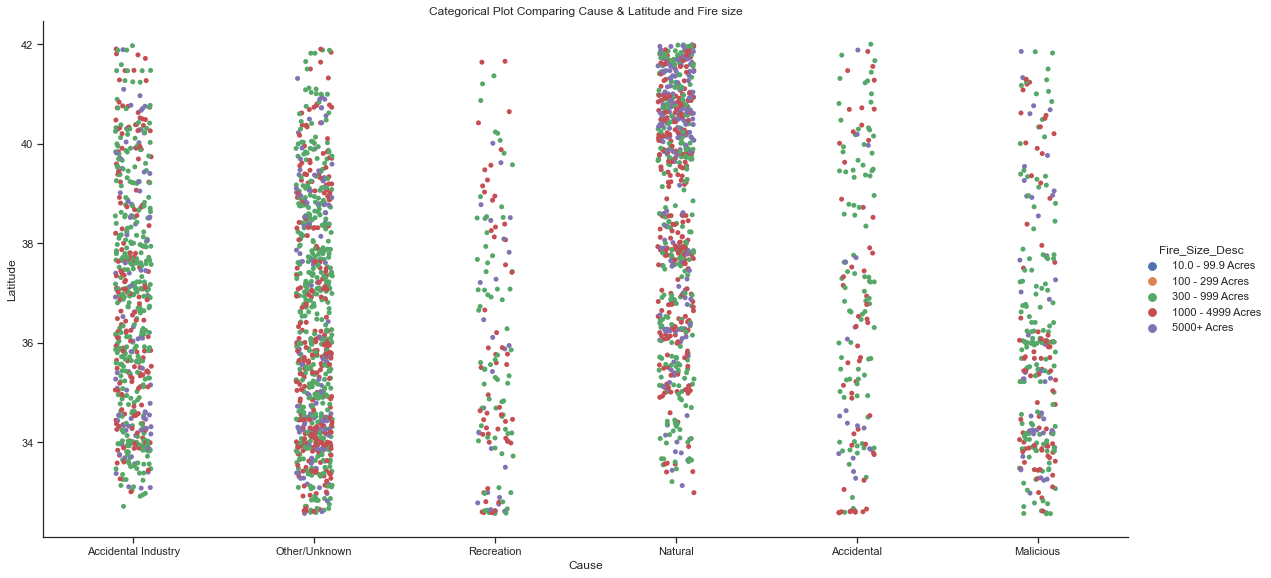

In [27]:
sns.set(style='ticks')
cat_plot = sns.catplot(x = 'Cause_cat', y = 'LATITUDE', data = df_CA_2, hue = 'Fire_Size_Desc', hue_order = ['10.0 - 99.9 Acres','100 - 299 Acres','300 - 999 Acres','1000 - 4999 Acres','5000+ Acres'],height=8, aspect=2, sizes=(25, 25))

plt.title('Categorical Plot Comparing Cause & Latitude and Fire size')
plt.xlabel('Cause')
plt.ylabel('Latitude')

##### Subset dataframe for Latitude and Fire Size for Natural cause wildfires in California

In [28]:
df_CA_3 = df_CA.apply(lambda row: row[df['Cause_cat'].isin(['Natural'])])

##### Hypothesis:

The higher north in California you go i.e., the bigger the latitude, the higher the number of larger natural cause wildfires there are

#### Checking extreme values

/Users/faridchehraz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LATITUDE', ylabel='Density'>

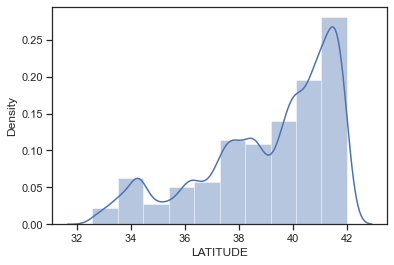

In [29]:
# Checking for extreme values in "Latitude"

sns.distplot(df_CA_3['LATITUDE'], bins=10)

/Users/faridchehraz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='FIRE_SIZE', ylabel='Density'>

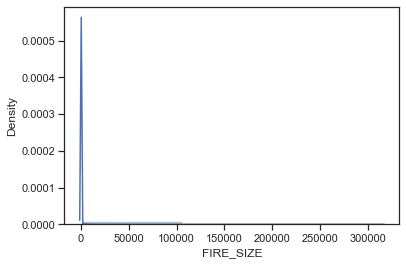

In [30]:
# Checking for extreme values in "Fire Size"

sns.distplot(df_CA_3['FIRE_SIZE'], bins=3)

In [31]:
# Checking the mean, median and max values

df_CA_3[['LATITUDE', 'FIRE_SIZE']].describe()

,LATITUDE,FIRE_SIZE
count,29194.000000,29194.000000
mean,39.120399,165.418797
std,2.416470,3052.959946
min,32.574000,0.010000
25%,37.651097,0.100000
50%,39.885556,0.100000
75%,41.133333,0.500000
max,42.011900,315578.800000


Extreme values identified in the fire size data were not deleted based on the assumption that they are correct

### 5. Data prep for regression analysis

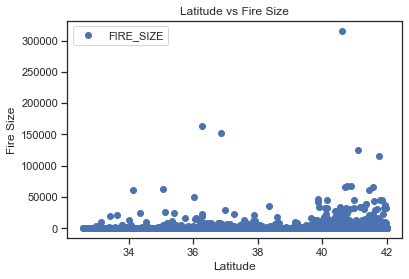

In [32]:
# Create a scatterplot using matplotlib for another look at how the chosen variables plot against each other.

df_CA_3.plot(x = 'LATITUDE', y='FIRE_SIZE',style='o') # The style option creates a scatterplot; without it, we only have lines.
plt.title('Latitude vs Fire Size')
plt.xlabel('Latitude')  
plt.ylabel('Fire Size')

#specify x-axis locations
#x_ticks = [20, 40, 60, 80, 100, 120]

#specify x-axis labels
#x_labels = ['Accidental Industry', 'Other/Unknown', 'Recreation', 'Natural', 'Accidental', 'Malicious'] 

#add x-axis values to plot
#plt.xticks(ticks=x_ticks, labels=x_labels)

plt.rcParams["figure.figsize"] = (12,12)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

plt.show()

In [33]:
df_CA_3.head()

,FOD_ID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,NWCG_GENERAL_CAUSE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,COUNTY,FIPS_NAME,DISC_MONTH,DISC_DOW,Fire_Size_Desc,Cause_cat,Cause_cat_num
1,2,2004,2004-05-12,133,Natural,0.25,A,38.933056,-120.404444,USFS,CA,61,Placer County,5,Wednesday,0.0 - 0.25 Acres,Natural,1
3,4,2004,2004-06-28,180,Natural,0.10,A,38.559167,-119.913333,USFS,CA,3,Alpine County,6,Monday,0.0 - 0.25 Acres,Natural,1
4,5,2004,2004-06-28,180,Natural,0.10,A,38.559167,-119.933056,USFS,CA,3,Alpine County,6,Monday,0.0 - 0.25 Acres,Natural,1
5,6,2004,2004-06-30,182,Natural,0.10,A,38.635278,-120.103611,USFS,CA,5,Amador County,6,Wednesday,0.0 - 0.25 Acres,Natural,1
6,7,2004,2004-07-01,183,Natural,0.10,A,38.688333,-120.153333,USFS,CA,17,El Dorado County,7,Thursday,0.0 - 0.25 Acres,Natural,1


In [34]:
# Reshape the variables into NumPy arrays and put them into separate objects.

X = df_CA_3['LATITUDE'].values.reshape(-1,1)
y = df_CA_3['FIRE_SIZE'].values.reshape(-1,1)

In [35]:
X

array([[38.93305556],
       [38.55916667],
       [38.55916667],
       ...,
       [37.9487    ],
       [34.4499    ],
       [33.616128  ]])

In [36]:
y

array([[0.25],
       [0.1 ],
       [0.1 ],
       ...,
       [0.01],
       [0.21],
       [0.02]])

In [37]:
# Split data into a training set and a test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### 6. Regression analysis

In [38]:
# Create a regression object.

regression = LinearRegression()  # This is the regression object, which will be fit onto the training set.

In [39]:
# Fit the regression object onto the training set.

regression.fit(X_train, y_train)

LinearRegression()

In [40]:
# Predict the values of y using X.

y_predicted = regression.predict(X_test)

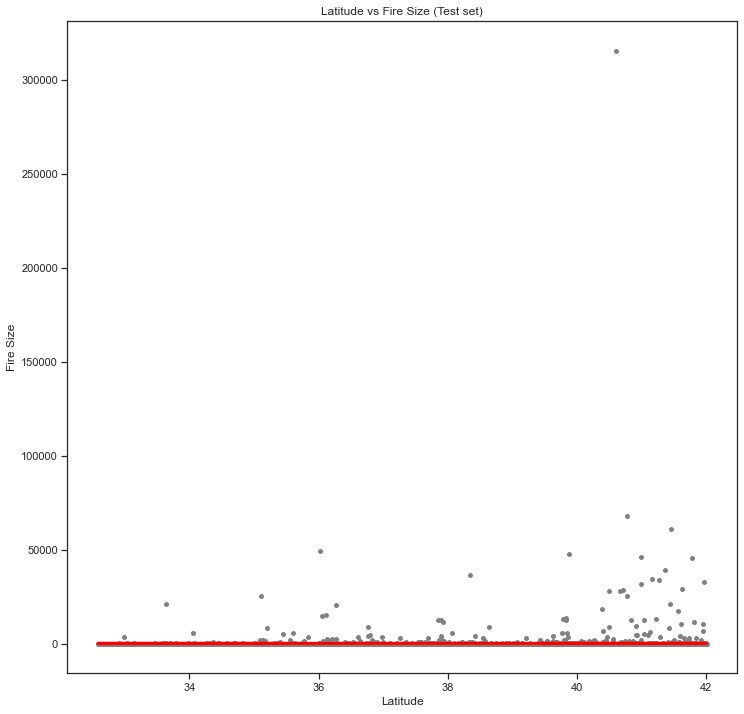

In [41]:
# Create a plot that shows the regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X_test, y_test, color='gray', s = 15)
plot_test.plot(X_test, y_predicted, color='red', linewidth =3)
plot_test.title('Latitude vs Fire Size (Test set)')
plot_test.xlabel('Latitude')
plot_test.ylabel('Fire Size')
plot_test.show()

In [42]:
# Create objects that contain the model summary statistics.

rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
r2 = r2_score(y_test, y_predicted) # This is the R2 score. 

In [43]:
# Print the model summary statistics. This is where you evaluate the performance of the model.

print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[2.02331606]]
Mean squared error:  15274405.480528114
R2 score:  -2.596944647104138e-05


In [44]:
y_predicted

array([[156.99582392],
       [159.96560226],
       [159.0388111 ],
       ...,
       [146.38690326],
       [154.34134558],
       [148.98293027]])

In [45]:
# Create a dataframe comparing the actual and predicted values of y.

data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(30)

,Actual,Predicted
0,0.20,156.995824
1,10.00,159.965602
2,0.20,159.038811
3,3.50,158.246908
4,0.10,160.909254
5,0.30,160.463001
6,0.25,156.963226
7,0.10,161.353260
8,0.10,149.859701
9,0.10,143.668353


##### Compare how the regression fits the training set

In [46]:
# Predict.

y_predicted_train = regression.predict(X_train) # This is predicting X_train!

In [47]:
rmse = mean_squared_error(y_train, y_predicted_train)
r2 = r2_score(y_train, y_predicted_train)

In [48]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[2.02331606]]
Mean squared error:  6767998.46445465
R2 score:  3.5360783736670953e-06


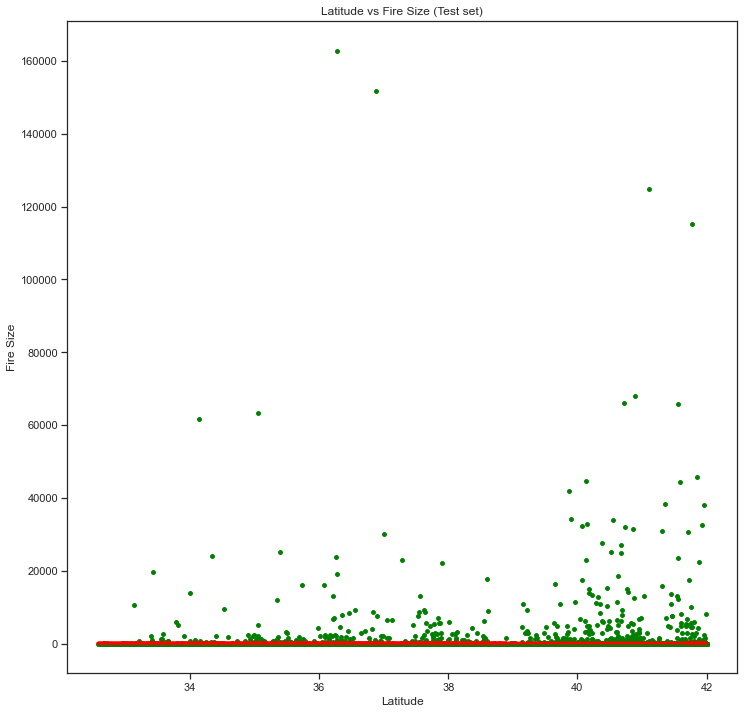

In [49]:
# Visualizing the training set results.

plot_test = plt
plot_test.scatter(X_train, y_train, color='green', s = 15)
plot_test.plot(X_train, y_predicted_train, color='red', linewidth =3)
plot_test.title('Latitude vs Fire Size (Test set)')
plot_test.xlabel('Latitude')
plot_test.ylabel('Fire Size')
plot_test.show()

The observations have a very high difference between the actual and predicted values. The model's statistics results show that the linear regression model is not a good fit. I will re-run a model excluding outliers.

Although there appears to be more daata points over the higher latitude degrees, there are many data points far from the line of best fit which would mean as above the linear regression model is not a good fit.

### 7. Performance improvement after removing outliers?

In [50]:
count = (df_CA_3['FIRE_SIZE'] > 30000).sum()
print(count)

38


In [51]:
# Cleaning the extreme values from the "Government Integrity" variable observed during the consistency checks.

df_test = df_CA_3[df_CA_3['FIRE_SIZE'] <=30000] 

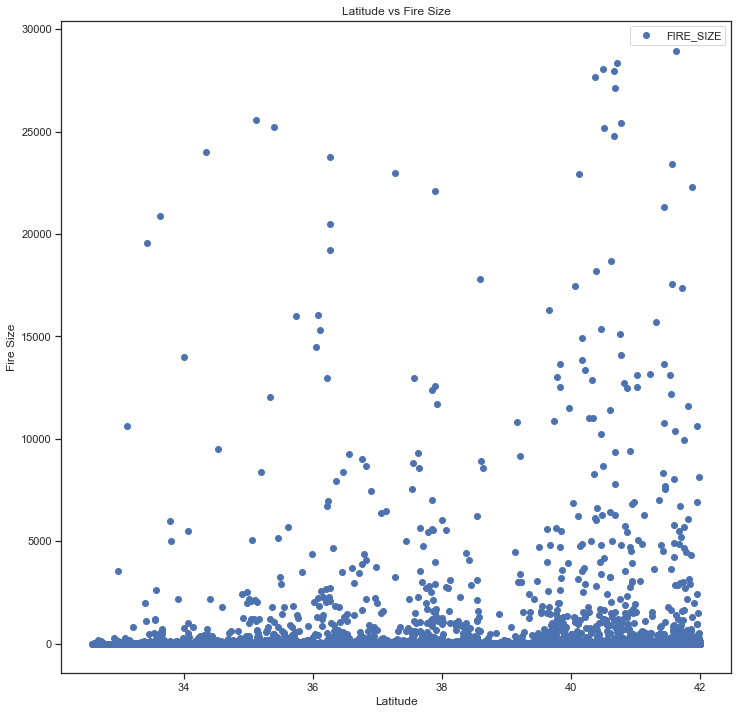

In [52]:
# Checking how the scatterplot looks without the outliers.

df_test.plot(x = 'LATITUDE', y='FIRE_SIZE', style='o')  
plt.title('Latitude vs Fire Size')  
plt.xlabel('Latitude')  
plt.ylabel('Fire Size')  
plt.show()

In [53]:
# Reshape again.

X_2 = df_test['LATITUDE'].values.reshape(-1,1)
y_2 = df_test['FIRE_SIZE'].values.reshape(-1,1)

In [54]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=0)

In [55]:
# Run and fit the regression.

regression = LinearRegression()  
regression.fit(X_train_2, y_train_2)

LinearRegression()

In [56]:
# Predict.

y_predicted_2 = regression.predict(X_test_2)

In [57]:
rmse = mean_squared_error(y_test_2, y_predicted_2)
r2 = r2_score(y_test_2, y_predicted_2)

In [58]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[1.12661603]]
Mean squared error:  1045642.7825917692
R2 score:  -0.00010230621716877941


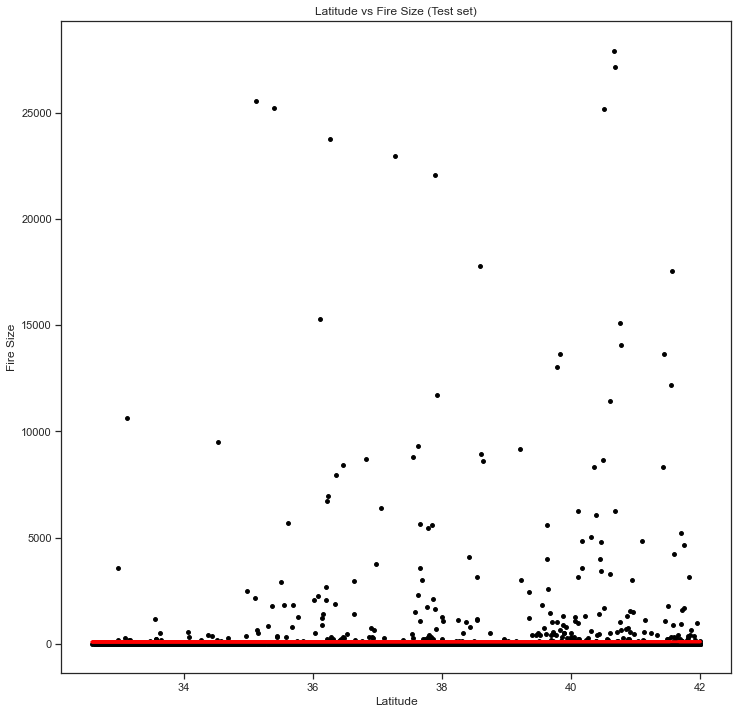

In [59]:
# Visualizing the test set results.

plot_test = plt
plot_test.scatter(X_test_2, y_test_2, color='black', s = 15)
plot_test.plot(X_train_2, regression.predict(X_train_2), color='red', linewidth =3)
plot_test.title('Latitude vs Fire Size (Test set)')
plot_test.xlabel('Latitude')
plot_test.ylabel('Fire Size')
plot_test.show()

In [60]:
data = pd.DataFrame({'Actual': y_test_2.flatten(), 'Predicted': y_predicted_2.flatten()})

In [61]:
data.head(30)

,Actual,Predicted
0,0.1,89.011070
1,0.1,87.617822
2,2941.0,83.517878
3,0.1,89.449512
4,0.1,79.888583
5,0.1,83.055027
6,0.2,87.405643
7,0.1,87.088312
8,0.1,87.766473
9,4.0,82.961368


Although the gap is now smaller, all observations still have a very high difference between the actual and predicted values. The model's statistics results show that the linear regression model is not a good fit.